In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cf



datetime.date(2020, 1, 1) + datetime.timedelta(322 - 1)



datetime.date(2020, 11, 17)

In [2]:
#filename = "igaPrf_F701.2020.322.00.01.R15_0001.0001_nc"

path = "C:\\Users\\Luiz Felipe\\Documents\\igaPrf_2020.322.00\\"

files = glob(path + '/*.0001_nc')

joined = []


parameter = 'ELEC_dens_orig

for filename in files:
    
    ds = xr.open_dataset(filename)
    
    #extract all values of altitude 
    alts = ds['MSL_alt'].values

    #define interval of choice
    condition = (alts > 280) & (alts < 320)
    values_selected = alts[condition]

    ds1 = ds.sel(MSL_alt = values_selected)

    lat = ds1['GEO_lat'].values.mean()
    lon = ds1['GEO_lon'].values.mean()
    data = ds1[parameter].values.mean()

    joined.append(np.vstack((lat, lon, data)).T)

    

C:\Users\Luiz Felipe\anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [16]:
filename = "igaPrf_F701.2020.322.00.01.R15_0001.0001_nc"

ds = xr.open_dataset(filename)
#extract all values of altitude 
alts = ds['MSL_alt'].values
#define interval of choice
condition = (alts > 100) & (alts < 500)
values_selected = alts[condition]


ds = ds.sel(MSL_alt = values_selected)
ds

<xarray.Dataset>
Dimensions:         (MSL_alt: 442)
Coordinates:
  * MSL_alt         (MSL_alt) float32 100.139305 101.53348 ... 499.7633
Data variables:
    GEO_lat         (MSL_alt) float32 ...
    GEO_lon         (MSL_alt) float32 ...
    ELEC_dens_orig  (MSL_alt) float32 ...
    ELEC_dens_bg    (MSL_alt) float32 ...
    ELEC_dens       (MSL_alt) float32 ...
    TEC_cal         (MSL_alt) float32 ...

In [43]:
df = pd.read_csv("iri_test.txt", header = None, delim_whitespace = True)

df[1] = df[1] / 10e6

df

,0,1
0,100.0,164.95
1,101.0,166.77
2,102.0,167.95
3,103.0,168.67
4,104.0,169.08
...,...,...
396,496.0,18977.00
397,497.0,18828.00
398,498.0,18680.00
399,499.0,18533.00


In [42]:
plt.plot(df[1], df[0])

plt.plot(ds['ELEC_dens'].values, ds['MSL_alt'].values)


df1 = ds['ELEC_dens'].to_dataframe()


for i in range(41):
    df1.iloc[i * 4, :] = np.nan
    
df1 = df1.dropna()

df1

,ELEC_dens
MSL_alt,
101.533478,46329.558594
102.925484,89453.023438
104.315331,132772.562500
107.088547,114727.898438
108.471909,101797.421875
...,...
498.070007,40287.980469
498.496521,43022.980469
498.920898,38334.062500


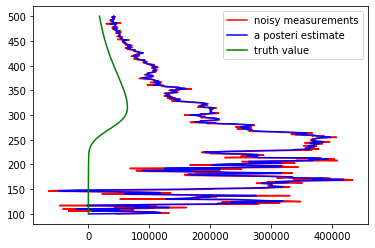

In [51]:

# intial parameters
n_iter = len(df)
sz = (n_iter,) # size of array
x =  df[1].values  # truth value (typo in example at top of p. 13 calls this z)
z =  df1['ELEC_dens'].values    #observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat = np.zeros(sz)      # a posteri estimate of x
P = np.zeros(sz)         # Covariância de estimativa do erro a posteri 
xhatminus=np.zeros(sz) # Estado de estimativa a priori de x
Pminus=np.zeros(sz)    # Covariância de estimativa do erro a priori 
K=np.zeros(sz)         # ganho de kalman (ou fator de combinação)

R = 0.1**5 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 1200
P[0] = 500.0

for k in range(1, n_iter):
    # time update
    xhatminus[k] = xhat[k - 1]
    Pminus[k] = P[k - 1] + Q
    
    # measurement update
    K[k] = Pminus[k] / ( Pminus[k] + R)
    xhat[k] = xhatminus[k] + K[k] * (z[k] - xhatminus[k])
 
    P[k] = (1 - K[k]) * Pminus[k]

plt.figure()
plt.plot(z, df[0], color = 'red', label='noisy measurements')
plt.plot(xhat, df[0], 'b-', label='a posteri estimate')
plt.plot(x, df[0], color='g',label='truth value')
plt.legend()



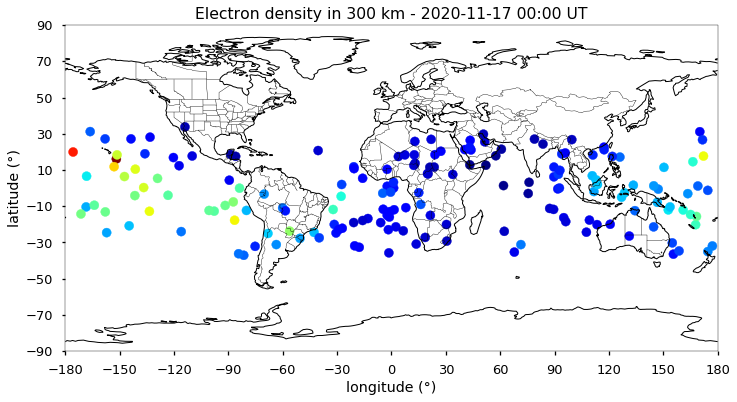

In [45]:
df = pd.DataFrame(np.concatenate(joined))

df.columns = ['lat', 'lon', 'ne']


fig, ax = plt.subplots(figsize = (12, 6), 
                       subplot_kw =dict(projection=ccrs.PlateCarree()))

plt.style.use('seaborn-talk')

ax.set_global()
states_provinces = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

ax.add_feature(cf.COASTLINE, edgecolor='black', lw = 1) 
ax.add_feature(cf.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

img = ax.scatter(df['lon'].values, df['lat'].values, c = df['ne'].values, 
                 cmap = 'jet', transform = ccrs.PlateCarree())

ax.set(xticks = np.arange(-180, 210, 30), xlabel = 'longitude (°)', ylabel = 'latitude (°)',
       yticks = np.arange(-90, 110, 20))

plt.show()

In [ ]:
values1 = []

doudt_lats = np.arange(-40, 40, 5)

for i in range(len(doudt_lats) - 1):
    for lats in df.index.values:
        if (lats > doudt_lats[i]) and (lats < doudt_lats[i + 1]):
            
            print(doudt_lats[i + 1], df.loc[lats, :].mean())



In [303]:
df = pd.DataFrame(np.concatenate(joined))

df.columns = ['lat', 'lon', 'ne']

df = pd.pivot_table(df, values = 'ne', columns = 'lon', index = 'lat')

lats = df.index.values

val = lats[(lats > 25) & (lats < 30)]

longitudes = []
data = []

lons = df.columns.values

for i in range(len(lons)):
    sel = df.loc[val, :].iloc[:, [i]]
    
    if sel.count().values != 0:
        longitudes.append(sel.columns.values)
    
    sel_data = sel.dropna().values
    
    data.extend(sel_data)
    

df1 = pd.DataFrame(np.concatenate(data), index = np.concatenate(longitudes))

df2 = pd.concat([df1, pd.DataFrame(index = df.columns.values)], axis = 1)

df2 = df2.drop(df2.loc[111:170].index)

# df2 = df2.interpolate().dropna()
#df2.plot(marker = 'o', linestyle = 'none')

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#      print(df2)

In [304]:
path = "C:\\Users\\Luiz Felipe\\Google Drive\\IRI\\"

files = glob(path + '/*.txt')

doubt = []

for filename in files:

    df = pd.read_csv(filename, header = None, delim_whitespace = True)

    df.columns = ['lat', 'lon', 'ne', 'tec']

    del df['tec']

    doubt.append(df)
       
df = pd.concat(doubt)

df = pd.pivot_table(df, values = 'ne', columns = 'lon', index = 'lat')

df = df / 10e6


model = np.concatenate(df.loc[df.index == 25].T.values)

observad = np.concatenate(df2.values)

observad


array([       nan,        nan,        nan,        nan,        nan,
              nan, 381342.12 ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 281666.9  ,
              nan,        nan,        nan,        nan,        nan,
       228746.1  ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

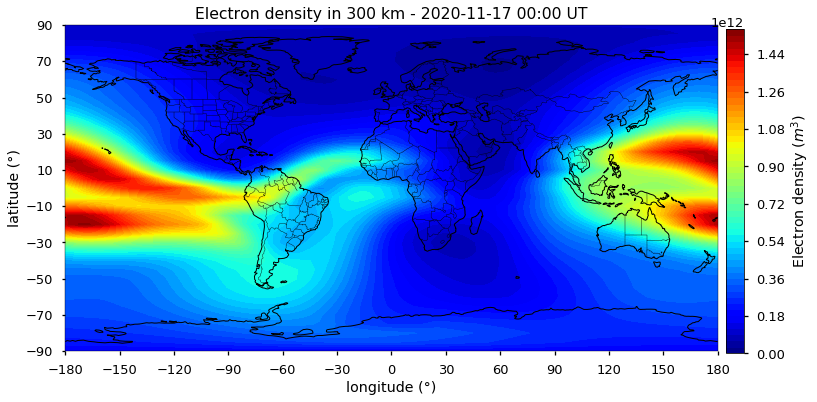

In [49]:
path = "C:\\Users\\Luiz Felipe\\Google Drive\\IRI\\"

files = glob(path + '/*.txt')

doubt = []

for filename in files:

    df = pd.read_csv(filename, header = None, delim_whitespace = True)

    df.columns = ['lat', 'lon', 'ne', 'tec']

    del df['tec']

    doubt.append(df)
       
df = pd.concat(doubt)

df = pd.pivot_table(df, values = 'ne', columns = 'lon', index = 'lat')

df = df / 10e6


fig, ax = plt.subplots( figsize = (12, 6), 
                       subplot_kw =dict(projection=ccrs.PlateCarree(), facecolor="gray"))
plt.style.use('seaborn-talk')

ax.set_global()
states_provinces = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

ax.add_feature(cf.COASTLINE, edgecolor='black', lw = 1) 
ax.add_feature(cf.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

img = ax.contourf(df.columns, df.index, df.values, 50, cmap = 'jet', transform = ccrs.PlateCarree())

cbar_ax = fig.add_axes([.9, 0.12, 0.02, 0.75]) 

fig.colorbar(img, cax=cbar_ax, label = 'Electron density ($m^3$)')

ax.set(xticks = np.arange(-180, 210, 30), xlabel = 'longitude (°)', ylabel = 'latitude (°)',
       yticks = np.arange(-90, 110, 20), title = 'Electron density in 300 km - 2020-11-17 00:00 UT')

plt.show()